
# <div style="padding:18px;color:white;margin:0;font-size:35px;text-align:center;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">Covid-19 Detection - Chest X-ray</div>

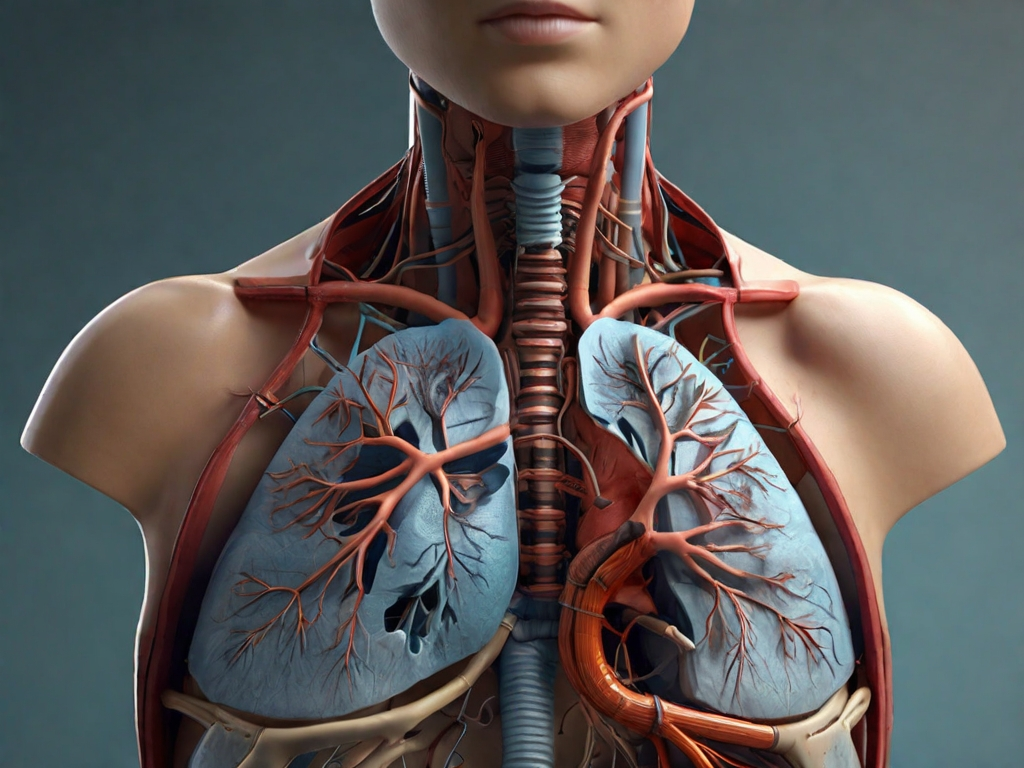


# <div style="padding:18px;color:white;margin:0;font-size:25px;text-align:left;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">1 | Importing libraries | Image loading</div>

In [ ]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import cv2

# Find directory paths for images
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Assign directory path for images
train_data_dir = "/kaggle/input/covid-19-vs-normal-chest-x-rays/"
train_normal_dir = train_data_dir + "NORMAL/NORMAL/"
train_covid_dir = train_data_dir + "COVID/COVID/"


# <div style="padding:18px;color:white;margin:0;font-size:25px;text-align:left;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">2 | Sample Images</div>

In [ ]:
def display_images(directory, num_images=5, image_size=(100, 100), title=''):
    plt.figure(figsize=(15, 3))
    plt.title(title)
    plt.axis('off')

    for i, image_name in enumerate(os.listdir(directory)[:num_images]):
        image_path = os.path.join(directory, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(image_name)

    plt.show()

display_images(train_normal_dir, title='NORMAL Images')

display_images(train_covid_dir, title='COVID Images')


# <div style="padding:18px;color:white;margin:0;font-size:25px;text-align:left;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">3 | Image preprocessing</div>

In [ ]:
# grayscale 
# resize 
# data augmentation !!
# standardize (0-1)




# <div style="padding:18px;color:white;margin:0;font-size:25px;text-align:left;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">4 | CNN</div>

In [ ]:
# tensorflow
# 

In [ ]:
#model.summary()

#history = model.fit()

#plt.figure(figsize=(12, 4))
#plt.show()


# <div style="padding:18px;color:white;margin:0;font-size:25px;text-align:left;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">5 | Evaluation</div>

In [ ]:
#evaluation = model.evaluate(...)

#predictions = model.predict(...)

#predicted_labels = 
#true_labels = 

#conf_matrix = confusion_matrix(true_labels, predicted_labels)

#plt.figure(figsize=(6, 6))
#sns.heatmap(...)
#plt.show()